# Classification Metric : Development & Test

## General

### Imports

In [ ]:
import pyvdirs.dirs as dirs
import sys
import os
sys.path.insert(0, dirs.SYSTEM_HOME)
sys.path.insert(0, os.path.join(dirs.SYSTEM_HOME, "ToyExample"))

import copy
import pickle
import builtins
import numpy as np
import torch
import matplotlib.pyplot as plt
import pyvtools.text as vtext
import math

import ToyExample.toy_example as toy
import mandala_exploration.fractal_step_by_step as mand
import utils

%load_ext autoreload
%autoreload 2

### Parameters

In [2]:
# Network parameters
classes='A'
num_layers=4
hidden_dim=64
batch_size=4<<10
total_iter=4<<10

# Distribution parameters
P_mean=-2.3
P_std=1.5
sigma_data=0.5
sigma_max=5
lr_ref=1e-2
lr_iter=512
ema_std=0.010

# Guidance parameters
guidance=False
guidance_weight=3
guide_path=os.path.join(dirs.MODELS_HOME, "ToyExample", "10_EarlyStopACID", "Ref", "iter0512.pkl")
guide_interpolation=False

# ACID parameters
acid=False
acid_n=16
acid_f=0.8
acid_diff=True
acid_inverted=False

# Training parameters
val_batch_size=4<<7
test_batch_size=4<<8

# Other parameters
device=torch.device('cuda')
fig1_kwargs = dict(view_x=0.30, view_y=0.30, view_size=1.2, device=device)
fig2_kwargs = dict(view_x=0.45, view_y=1.22, view_size=0.3, device=device)#, sample_distance=0.045, sigma_max=0.03)
seed=0

In [3]:
# Set random seed, if specified
if seed is not None:
    print("Seed = ", seed)
    torch.manual_seed(seed)
    generator = torch.Generator(device).manual_seed(seed)
    np.random.seed(seed)

Seed =  0


In [6]:
# Initialize models
gtd, gtd_comps = toy.gt(classes, device)
net = toy.ToyModel(num_layers=num_layers, hidden_dim=hidden_dim, sigma_data=sigma_data).to(device).train().requires_grad_(True)
ema = copy.deepcopy(net).eval().requires_grad_(False)
opt = torch.optim.Adam(net.parameters(), betas=(0.9, 0.99))
if guide_path is not None:
    with builtins.open(guide_path, "rb") as f:
        guide = pickle.load(f).to(device)
    print("Guide model loaded")
else:
    guide = None
if guidance and acid:
    ref = guide
    print("Guide model assigned as ACID reference")
elif acid: 
    ref = ema
    print("EMA assigned as ACID reference")
else: ref = None

Guide model loaded


## Plots

In [6]:
print("Original threshold for logp is set to", -2.12, "meaning probability density of", math.exp(-2.12))

Original threshold for logp is set to -2.12 meaning probability density of 0.12003162851145673


In [7]:
gtd_comps

[{'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.02134411, 0.06333431]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.05188869, 0.09552517]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.08243328, 0.12771604]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.11297786, 0.1599069 ]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.14352244, 0.19209777]),
  'Sigma': array([[0.00034676, 0.00010358],
         [0.00010358, 0.00038515]]),
  'depth': 0},
 {'cls': 'A',
  'phi': 0.2676613417115205,
  'mu': array([0.17406703, 0.22428864]),
  'Sigma': array

Point (x,y) : log(PDF(x,y)) : PDF(x,y)
(0.3, 0.3) : 2.0693705081939697 : 7.9198360764480915
(0.2, 0.2) : 0.48671233654022217 : 1.6269585255381334
(0.3, 0.2) : -16.56256103515625 : 6.411669624112501e-08
(0.4, 0.2) : -3.1475229263305664 : 0.042958406318854316
(0.3, 0.1) : -56.93898391723633 : 1.8694483878925558e-25


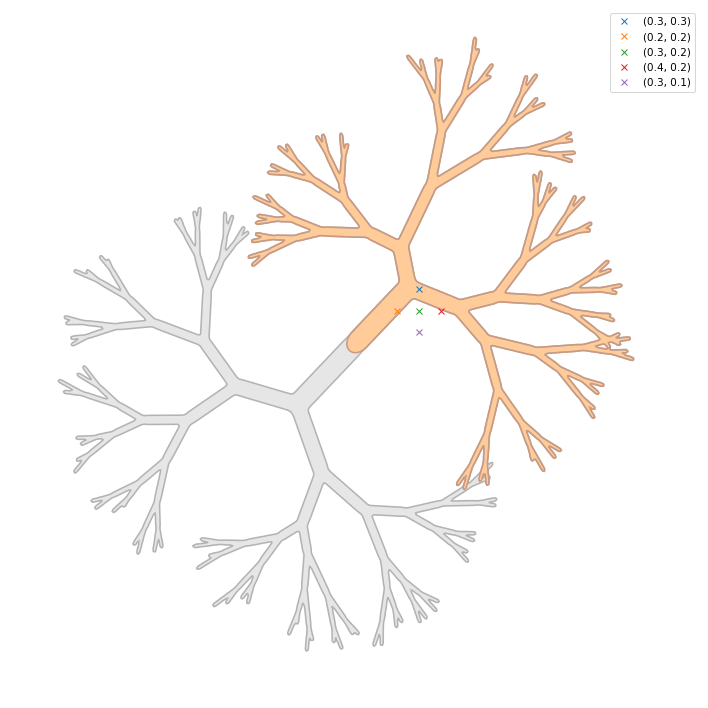

In [ ]:
points = [(.3,.3), (.2,.2), (.3,.2), (.4,.2), (.3,.1)]

fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_uncond', 'gt_outline'}, ax=ax, device=device)
print("Point (x,y) : log(PDF(x,y)) : PDF(x,y)")
for p in points:
    gt_logp = float(gtd.logp(torch.Tensor(p).reshape((1,2)).to(device)))
    print(p, ":", gt_logp, ":", math.exp(gt_logp))
    plt.plot(*p,"x",label=str(p))
plt.legend()

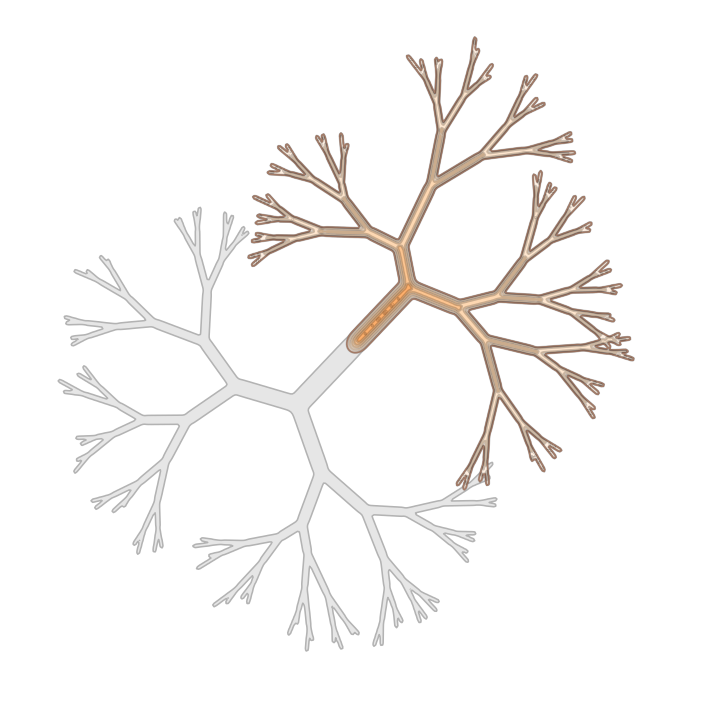

In [10]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_uncond', 'gt_outline', 'gt_shaded'}, ax=ax, device=device)

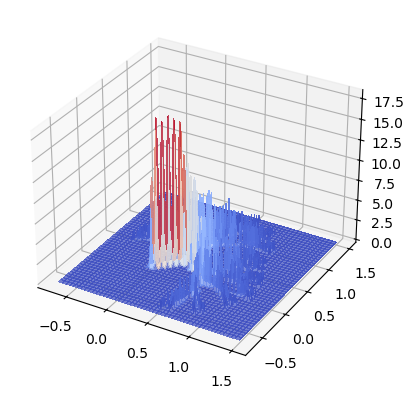

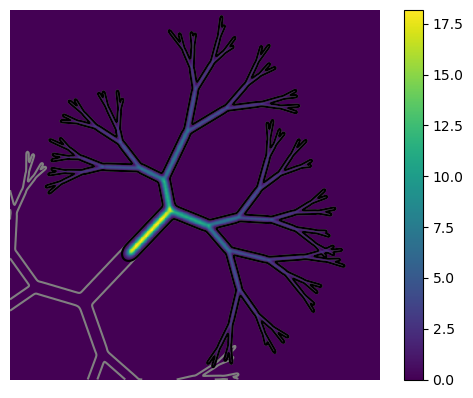

In [ ]:
grid_resolution = 801
zoom_out = 1

x_centre = .4
y_centre = .4
y_side = x_side = 2*1.1

samples = utils.create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)
f_samples = gtd.pdf(samples)

samples = samples.swapaxes(0,2).swapaxes(1,2).cpu().numpy()
f_samples = f_samples.detach().cpu().numpy()

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(*samples, f_samples, cmap="coolwarm", 
                linewidth=0, antialiased=False, alpha=0.7)

fig, ax = plt.subplots()
plt.pcolormesh(*samples, f_samples)
ax.set_aspect("equal")
plt.colorbar()
toy.do_plot(ema, elems={'gt_uncond_transparent', 'gt_outline_transparent'}, ax=ax, 
            view_x=x_centre, view_y=y_centre, view_size=x_side/2)

## Old plots

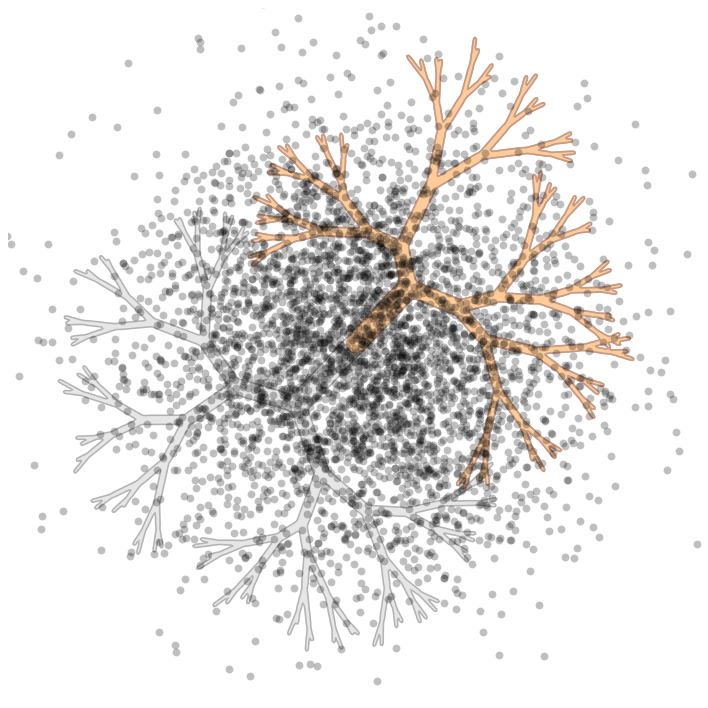

In [12]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples','gt_uncond', 'gt_outline'}, ax=ax,
            sigma_max=sigma_max, device=device, num_samples=1<<12)

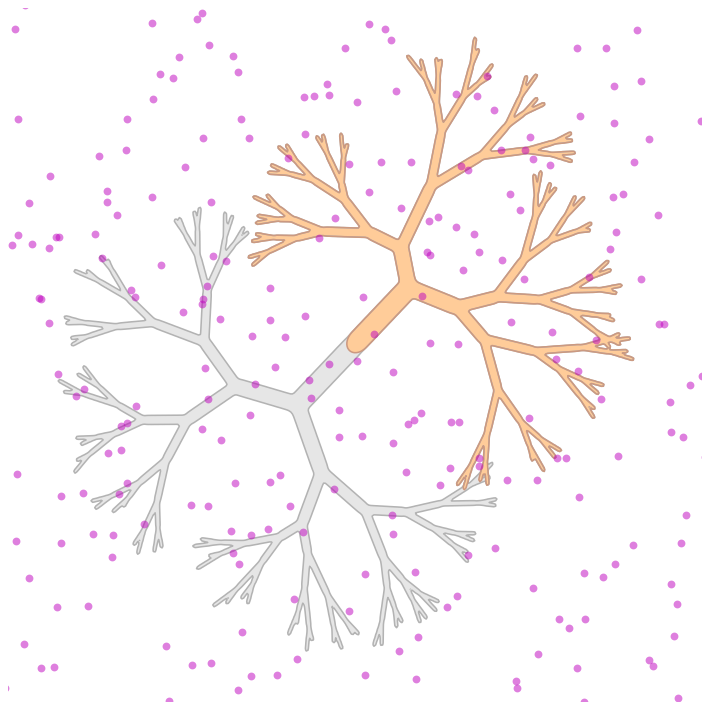

In [13]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples_before_small','gt_uncond', 'gt_outline'}, ax=ax, num_samples=1<<12)

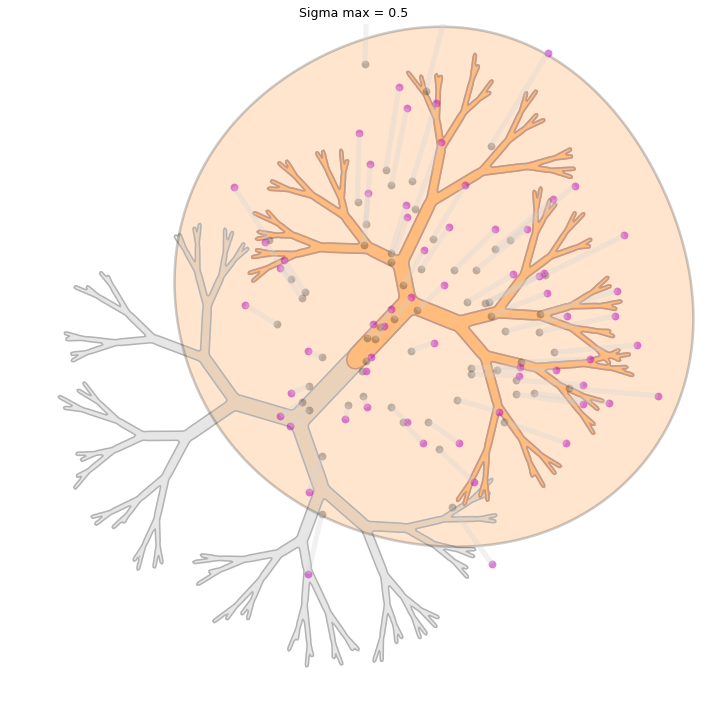

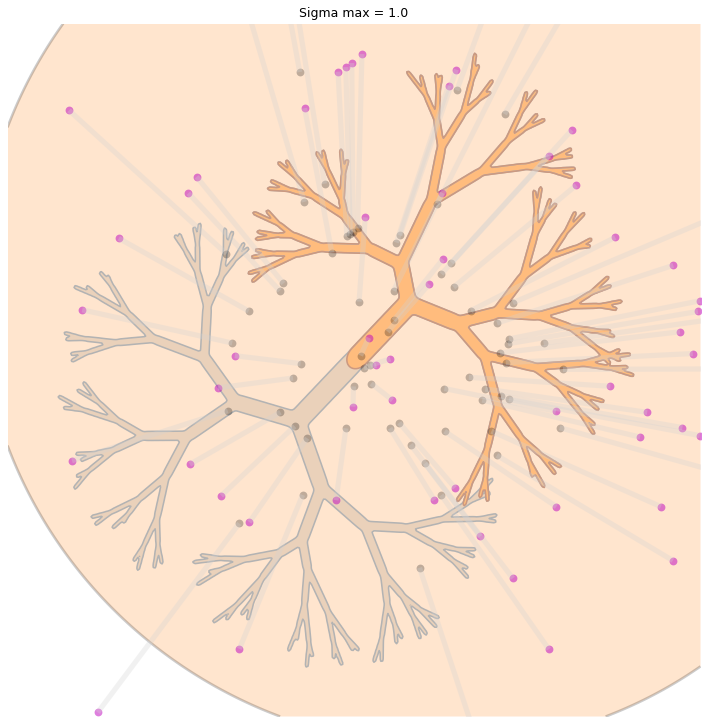

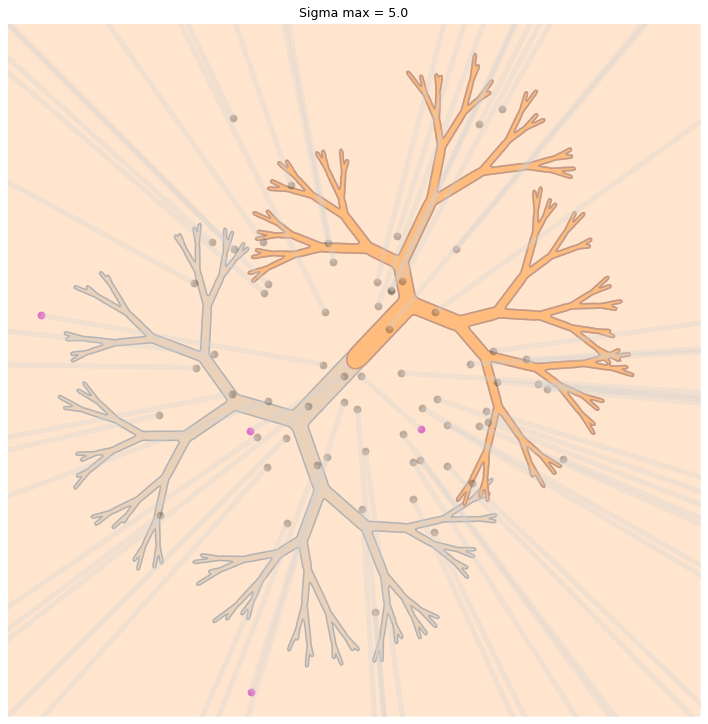

In [14]:
for sigma_max in [0.5,1,5]:
    fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
    toy.do_plot(ema, elems={'samples_before_small',
                            'trajectories_small', 'samples',
                            'gt_smax',
                            'gt_uncond', 'gt_outline'}, 
                num_samples=1<<6, sigma_max=sigma_max, ax=ax)
    plt.title(f"Sigma max = {sigma_max:.1f}")

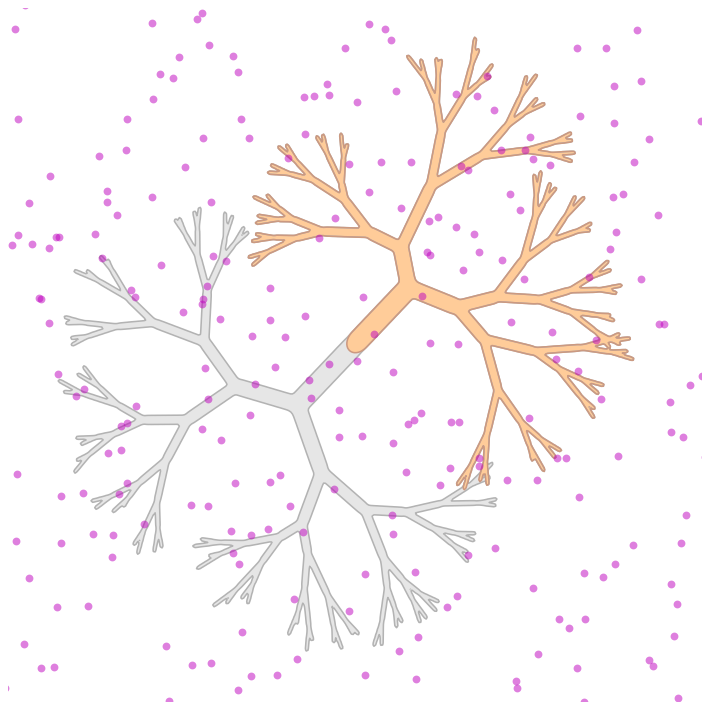

In [16]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'samples_before_small','gt_uncond', 'gt_outline'}, num_samples=1<<12, ax=ax)

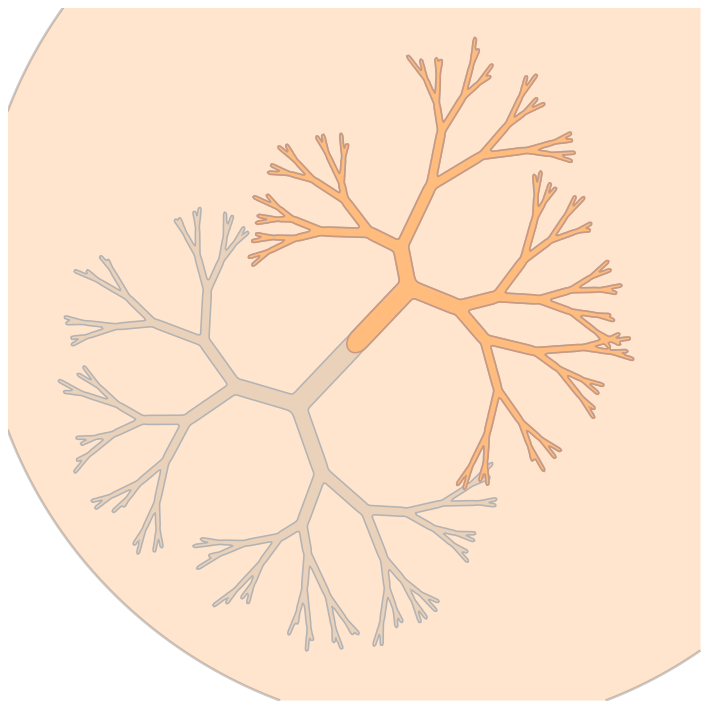

In [17]:
fig, ax = plt.subplots(figsize=[12, 12], dpi=75)
toy.do_plot(ema, elems={'gt_smax','gt_uncond', 'gt_outline'}, num_samples=1<<12, sigma_max=1, ax=ax)

## Luis' metric

In [ ]:
# Parameters
grid_resolution = 100  # Increased grid resolution
start_pos = (0, -60)  # Moved starting position even further down
# start_length = 40
max_depth = 7
n_scatter = 1000

# Create grid
samples = utils.create_grid_samples(grid_resolution, x_centre, y_centre, x_side, y_side)
cell_size, bounds = utils.get_grid_params(grid_resolution, x_centre, y_centre, x_side, y_side)
cell_size = cell_size[0] # Squared symmetric grid ==> Retain just one
bounds = (*bounds[0], *bounds[1])

# Calculate bounds to ensure square aspect ratio and prevent cutoff
# margin = start_length * 2.5  # Increased margin to prevent cutoff
# bounds = [-margin, margin, -margin, margin]
# cell_size = (bounds[1] - bounds[0]) / grid_resolution

# Create figure with square aspect ratio
plt.figure(figsize=(15, 5))

# 1. Draw fractal with scatter
ax1 = plt.subplot(131, aspect='equal')
ax1.set_title("Fractal Tree with Scatter")

# Draw fractal and collect line segments with thickness
toy.do_plot(ema, elems={'gt_uncond_transparent', 'gt_outline_transparent'},
            view_x=x_centre, view_y=y_centre, view_size=x_side/2, ax=ax)
# fractal_segments = mand.draw_fractal(ax1, start_pos, 90, start_length, max_depth, 'gray')

# # Generate and plot scatter points
# scatter_x, scatter_y = generate_scatter_points(start_pos, start_length*3, n_scatter)
# ax1.scatter(scatter_x, scatter_y, color='red', alpha=0.4, s=10, zorder=10)

# # 2. Ground Truth Grid
# ax2 = plt.subplot(132, aspect='equal')
# ax2.set_title("Ground Truth Grid")

# # Create grid
# grid = np.zeros((grid_resolution, grid_resolution))

# # Mark ground truth cells considering branch width
# for start, end, thickness in fractal_segments:
#     mark_cells_along_line(grid, start, end, thickness/20, cell_size, bounds)  # Reduced thickness by factor of 20

# # Plot ground truth grid
# x_edges = np.linspace(bounds[0], bounds[1], grid_resolution + 1)
# y_edges = np.linspace(bounds[2], bounds[3], grid_resolution + 1)

# ax2.pcolormesh(x_edges, y_edges, grid, 
#                 cmap=plt.matplotlib.colors.ListedColormap(['white', '#0000FF']), 
#                 alpha=0.3)

# # Add thin grid lines
# for x in x_edges:
#     ax2.axvline(x=x, color='gray', alpha=0.2, linewidth=0.1)
# for y in y_edges:
#     ax2.axhline(y=y, color='gray', alpha=0.2, linewidth=0.1)

# # 3. Hit/Miss Visualization
# ax3 = plt.subplot(133, aspect='equal')
# ax3.set_title("Hit/Miss Analysis")

# # Create visualization grid starting with ground truth
# vis_grid = grid.copy()  # Start with ground truth (will be 1s and 0s)
# hit_cells = set()
# miss_cells = set()

# # Mark hits and misses
# for x, y in zip(scatter_x, scatter_y):
#     i, j = point_to_cell((x, y), bounds[0], bounds[2], cell_size)
#     if 0 <= i < grid_resolution and 0 <= j < grid_resolution:
#         if grid[i, j] > 0:
#             vis_grid[i, j] = 2  # Hit
#             hit_cells.add((i, j))
#         else:
#             vis_grid[i, j] = 3  # Miss
#             miss_cells.add((i, j))

# # Plot hit/miss grid with ground truth visible
# colors = ['white', '#0000FF', '#00FF00', '#FF0000']  # White, Ground Truth, Hit, Miss
# ax3.pcolormesh(x_edges, y_edges, vis_grid, 
#                 cmap=plt.matplotlib.colors.ListedColormap(colors), 
#                 alpha=0.3)

# # Add thin grid lines
# for x in x_edges:
#     ax3.axvline(x=x, color='gray', alpha=0.2, linewidth=0.1)
# for y in y_edges:
#     ax3.axhline(y=y, color='gray', alpha=0.2, linewidth=0.1)

# # Set bounds and remove axis numbers for all plots
# for ax in [ax1, ax2, ax3]:
#     ax.set_xlim(bounds[0], bounds[1])
#     ax.set_ylim(bounds[2], bounds[3])
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

# plt.tight_layout()

# # Calculate metrics
# ground_truth_cells = np.sum(grid > 0)
# n_hits = len(hit_cells)
# n_misses = len(miss_cells)
# mandala_score = n_hits / ground_truth_cells if ground_truth_cells > 0 else 0

# # Add stats only to the last plot
# stats_text = f"Ground Truth: {ground_truth_cells}\nHits: {n_hits}\nMisses: {n_misses}\nMandala Score: {mandala_score:.3f}"
# ax3.text(0.02, 0.98, stats_text,
#             transform=ax3.transAxes,
#             verticalalignment='top',
#             fontsize=8,
#             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

# plt.savefig('fractal_analysis_step_by_step_new.png', dpi=300, bbox_inches='tight')
# plt.close()